# 1.1 Reinforcement Learning Fundamentals

## Learning Objectives
- Understand core RL concepts: Agent, Environment, State, Action, Reward
- Learn the Markov Decision Process (MDP) framework
- Understand the exploration vs exploitation tradeoff
- Implement a simple RL agent from scratch

## What is Reinforcement Learning?

Reinforcement Learning (RL) is a type of machine learning where an **agent** learns to make decisions by interacting with an **environment**.

```
┌─────────┐    action     ┌─────────────┐
│  Agent  │──────────────▶│ Environment │
│         │◀──────────────│             │
└─────────┘  state, reward└─────────────┘
```

### Key Components:
1. **Agent**: The learner/decision maker
2. **Environment**: What the agent interacts with
3. **State (s)**: Current situation of the agent
4. **Action (a)**: What the agent can do
5. **Reward (r)**: Feedback signal from environment
6. **Policy (π)**: Strategy that maps states to actions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import random

## The Multi-Armed Bandit Problem

Let's start with the simplest RL problem - the multi-armed bandit.

Imagine you're in a casino with multiple slot machines (bandits). Each machine has a different (unknown) probability of winning. Your goal: maximize total reward over time.

This illustrates the **exploration vs exploitation** tradeoff:
- **Exploration**: Try new machines to learn their payoffs
- **Exploitation**: Use the best known machine

In [2]:
class MultiArmedBandit:
    
    def __init__(self, 
                 n_arms: int = 10):
        self.n_arms = n_arms
        # True probabilities (unknown to the agent)
        self.true_probs = np.random.uniform(0, 1, n_arms)
        print(f"True probabilities: {self.true_probs}")
    
    def pull(self, 
             arm: int) -> float:
        """Pull an arm and get reward (1 or 0)."""
        if random.random() < self.true_probs[arm]:
            return 1.0
        return 0.0
    
    def optimal_arm(self) -> int:
        """Return the best arm (for evaluation)."""
        return np.argmax(self.true_probs)

In [3]:
class EpsilonGreedyAgent:
    
    def __init__(self, 
                 n_arms: int, 
                 epsilon: float = 0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.q_values: np.ndarray = np.zeros(n_arms)  # Estimated values | [q1, q2, ..., qn]
        self.n_pulls: np.ndarray = np.zeros(n_arms)   # Number of pulls per arm | [n1, n2, ..., nn]
    
    def select_arm(self) -> int:
        if random.random() < self.epsilon:
            # Explore: random arm
            return random.randint(0, self.n_arms - 1)
        else:
            # Exploit: best known arm
            return np.argmax(self.q_values)
    
    def update(self, 
               arm: int, 
               reward: float):
        self.n_pulls[arm] += 1  # Update count for arm | n_arm = n_arm + 1
        # Incremental mean update
        self.q_values[arm] =  self.q_values[arm] + (reward - self.q_values[arm]) / self.n_pulls[arm]  # Update estimate | q_arm = q_arm + (reward - q_arm) / n_arm   

### Understanding the Update Formula

```python
Q = Q + (reward - Q) / n
```

This computes a **running average** without storing all past rewards:

```
Step 1: Q = 0 + (1 - 0) / 1 = 1.0      # Got reward 1
Step 2: Q = 1 + (0 - 1) / 2 = 0.5      # Got reward 0, average = (1+0)/2
Step 3: Q = 0.5 + (1 - 0.5) / 3 = 0.67 # Got reward 1, average = (1+0+1)/3
```

**Why this works:** `(reward - Q)` is the "error" between what we got and what we expected. We adjust Q by a fraction `1/n` of this error.

## Key Concepts

### What is a "Bandit"?
A **multi-armed bandit** is like a row of slot machines. Each "arm" (machine) has a hidden probability of paying out. You don't know which is best - you have to learn by trying them.

### What are Q-Values?
**Q-values** are the agent's **estimates** of how good each arm is. They start at 0 and update as the agent learns:

```
Q(arm) = running average of rewards from that arm
```

The agent's goal: make Q-values match the true (hidden) probabilities.

True probabilities: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258]


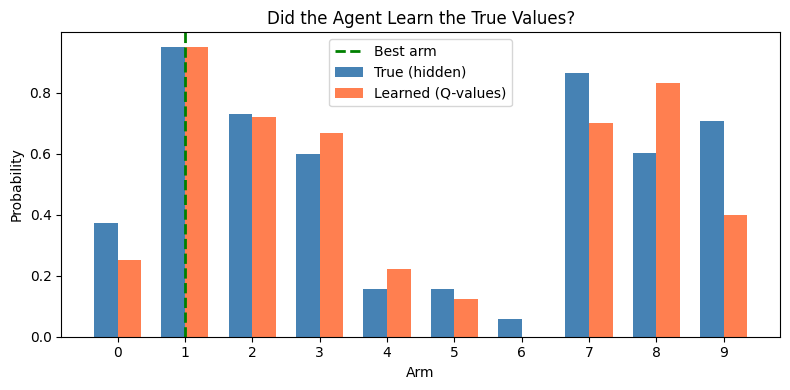


Best arm: 1 (true prob = 0.95)
Agent learned: 1 (estimate = 0.95)


In [4]:
def run_experiment(n_steps: int = 1000,
                   n_arms: int = 10, 
                   epsilon: float = 0.1):
    bandit = MultiArmedBandit(n_arms)
    agent = EpsilonGreedyAgent(n_arms, epsilon)
    
    for step in range(n_steps):
        arm = agent.select_arm()
        reward = bandit.pull(arm)
        agent.update(arm, reward)
    
    return {
        'true_probs': bandit.true_probs,
        'learned_values': agent.q_values,
        'optimal_arm': bandit.optimal_arm(),
    }

np.random.seed(42)
results = run_experiment(n_steps=1000, n_arms=10, epsilon=0.1)

# True vs Learned Values
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(results['true_probs']))
width = 0.35
ax.bar(x - width/2, results['true_probs'], width, label='True (hidden)', color='steelblue')
ax.bar(x + width/2, results['learned_values'], width, label='Learned (Q-values)', color='coral')
ax.axvline(x=results['optimal_arm'], color='green', linestyle='--', linewidth=2, label='Best arm')
ax.set_xlabel('Arm')
ax.set_ylabel('Probability')
ax.set_title('Did the Agent Learn the True Values?')
ax.legend()
ax.set_xticks(x)
plt.tight_layout()
plt.show()

print(f"\nBest arm: {results['optimal_arm']} (true prob = {results['true_probs'][results['optimal_arm']]:.2f})")
print(f"Agent learned: {np.argmax(results['learned_values'])} (estimate = {max(results['learned_values']):.2f})")

## Markov Decision Process (MDP)

Most RL problems are formalized as MDPs, which extend bandits to sequential decision making.

An MDP is defined by:
- **S**: Set of states
- **A**: Set of actions
- **P(s'|s,a)**: Transition probabilities
- **R(s,a,s')**: Reward function
- **γ (gamma)**: Discount factor (0 to 1)

### The Markov Property
"The future depends only on the present, not the past"

$$P(s_{t+1}|s_t, a_t, s_{t-1}, a_{t-1}, ...) = P(s_{t+1}|s_t, a_t)$$

## GridWorld: A Simple MDP

Let's implement a simple gridworld environment to understand MDPs better.

In [ ]:
class GridWorld:
    """
    Simple 4x4 GridWorld.
    
    Layout:
    S . . .
    . X . .
    . . . .
    . . . G
    
    S = Start, G = Goal (+1), X = Obstacle (-1)
    """
    
    def __init__(self):
        self.size = 4
        self.start = (0, 0)
        self.goal = (3, 3)
        self.obstacle = (1, 1)
        self.state = self.start
        
        # Actions: 0=up, 1=right, 2=down, 3=left
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.n_actions = 4
        self.n_states = self.size * self.size
    
    def reset(self) -> Tuple[int, int]:
        self.state = self.start
        return self.state
    
    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool]:
        dy, dx = self.actions[action]
        new_y = max(0, min(self.size - 1, self.state[0] + dy))
        new_x = max(0, min(self.size - 1, self.state[1] + dx))
        
        self.state = (new_y, new_x)
        
        # Check terminal states
        if self.state == self.goal:
            return self.state, 1.0, True
        elif self.state == self.obstacle:
            return self.state, -1.0, True
        else:
            return self.state, -0.01, False  # Small penalty for each step
    
    def state_to_idx(self, state: Tuple[int, int]) -> int:
        """Convert (y, x) to flat index."""
        return state[0] * self.size + state[1]
    
    def render(self):
        """Print the grid."""
        for y in range(self.size):
            row = ""
            for x in range(self.size):
                if (y, x) == self.state:
                    row += "A "  # Agent
                elif (y, x) == self.goal:
                    row += "G "
                elif (y, x) == self.obstacle:
                    row += "X "
                else:
                    row += ". "
            print(row)
        print()

In [10]:
# Test the environment
env = GridWorld()
state = env.reset()
print("Initial state:")
env.render()

# Take some random actions
print("Taking actions: right, down, right, down...")
for action in [1, 2, 1, 2, 1, 2]:  # right, down, right, down...
    state, reward, done = env.step(action)
    env.render()
    print(f"Reward: {reward}, Done: {done}")
    if done:
        break

Initial state:
A . . . 
. X . . 
. . . . 
. . . G 

Taking actions: right, down, right, down...
. A . . 
. X . . 
. . . . 
. . . G 

Reward: -0.01, Done: False
. . . . 
. A . . 
. . . . 
. . . G 

Reward: -1.0, Done: True


## Value Functions

Two key concepts in RL:

### State-Value Function V(s)
Expected return starting from state s, following policy π:

$$V^\pi(s) = E_\pi[\sum_{t=0}^{\infty} \gamma^t R_{t+1} | S_0 = s]$$

### Action-Value Function Q(s, a)
Expected return starting from state s, taking action a, then following π:

$$Q^\pi(s, a) = E_\pi[\sum_{t=0}^{\infty} \gamma^t R_{t+1} | S_0 = s, A_0 = a]$$

## Q-Learning: Our First RL Algorithm

Q-Learning is a model-free algorithm that learns Q-values directly from experience.

**Update rule:**
$$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$

Where:
- α (alpha): Learning rate
- γ (gamma): Discount factor
- r: Reward received
- s': Next state

In [ ]:
class QLearningAgent:
    """Q-Learning agent for GridWorld."""
    
    def __init__(self, n_states: int, n_actions: int, 
                 alpha: float = 0.1, gamma: float = 0.99, epsilon: float = 0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((n_states, n_actions))
    
    def select_action(self, state_idx: int) -> int:
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        return np.argmax(self.q_table[state_idx])
    
    def update(self, state_idx: int, action: int, reward: float, 
               next_state_idx: int, done: bool):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q_table[next_state_idx])
        
        # Q-Learning update
        self.q_table[state_idx, action] += self.alpha * (
            target - self.q_table[state_idx, action]
        )

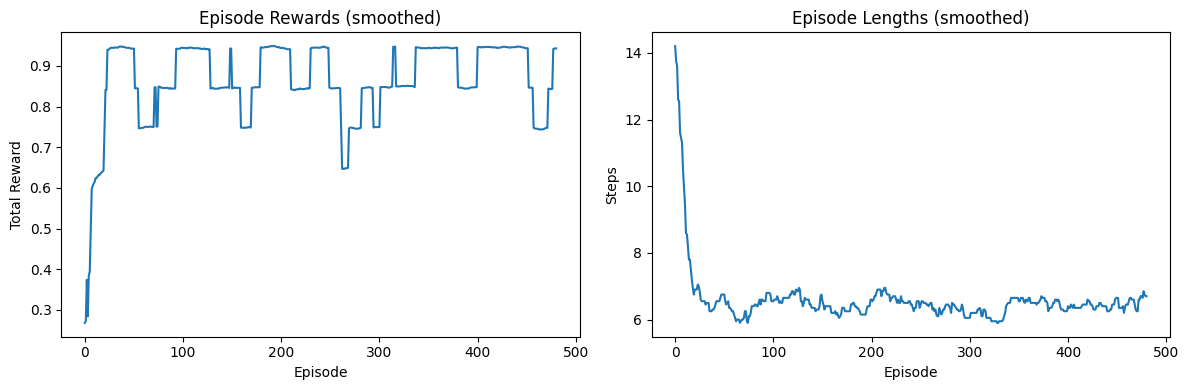

In [11]:
def train_q_learning(n_episodes: int = 500):
    """Train Q-Learning agent on GridWorld."""
    env = GridWorld()
    agent = QLearningAgent(env.n_states, env.n_actions)
    
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(n_episodes):
        state = env.reset()
        state_idx = env.state_to_idx(state)
        total_reward = 0
        steps = 0
        
        while True:
            action = agent.select_action(state_idx)
            next_state, reward, done = env.step(action)
            next_state_idx = env.state_to_idx(next_state)
            
            agent.update(state_idx, action, reward, next_state_idx, done)
            
            state_idx = next_state_idx
            total_reward += reward
            steps += 1
            
            if done or steps > 100:  # Max steps to prevent infinite loops
                break
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
    
    return agent, episode_rewards, episode_lengths

# Train the agent
agent, rewards, lengths = train_q_learning(n_episodes=500)

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Smooth the curves
window = 20
smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
smoothed_lengths = np.convolve(lengths, np.ones(window)/window, mode='valid')

axes[0].plot(smoothed_rewards)
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total Reward')
axes[0].set_title('Episode Rewards (smoothed)')

axes[1].plot(smoothed_lengths)
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Steps')
axes[1].set_title('Episode Lengths (smoothed)')

plt.tight_layout()
plt.show()

In [12]:
def visualize_policy(agent, env):
    """Show the learned policy as arrows."""
    arrows = ['↑', '→', '↓', '←']
    
    print("Learned Policy:")
    for y in range(env.size):
        row = ""
        for x in range(env.size):
            if (y, x) == env.goal:
                row += "G "
            elif (y, x) == env.obstacle:
                row += "X "
            else:
                state_idx = y * env.size + x
                best_action = np.argmax(agent.q_table[state_idx])
                row += arrows[best_action] + " "
        print(row)

env = GridWorld()
visualize_policy(agent, env)

Learned Policy:
↓ → ↓ ↓ 
↓ X → ↓ 
↓ ↓ → ↓ 
→ → → G 


## Key Takeaways

1. **RL is about learning from interaction** - The agent learns by trying actions and observing rewards

2. **Exploration vs Exploitation** - Balance trying new things with using what works

3. **Value Functions** - Estimate how good states/actions are for long-term reward

4. **Q-Learning** - Learn optimal policy without knowing environment dynamics